In [0]:
%ls

In [0]:


import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16, InceptionV3
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [0]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [0]:
# one hot encoding of labels
one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
0,resized/1.jpg,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
1,resized/2.jpg,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
2,resized/3.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0
3,resized/4.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4,resized/5.jpg,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0


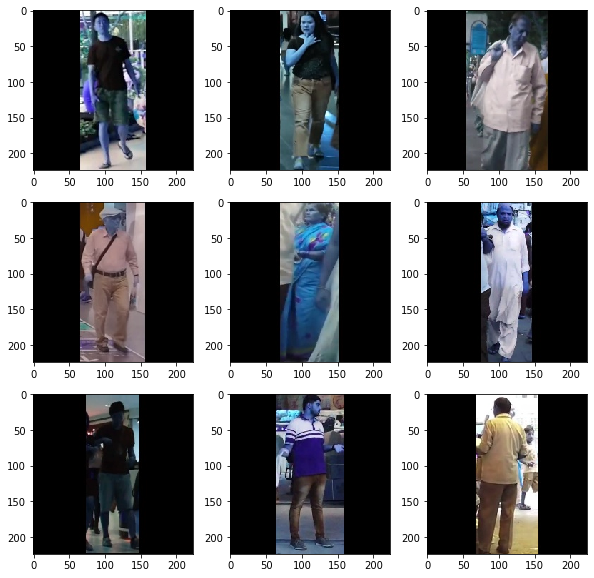

In [0]:
from matplotlib import pyplot as plt


fig = plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    item = one_hot_df.iloc[i]
    image = np.array(cv2.imread(item["image_path"]))
    plt.imshow(image)
    # print(image.shape)
plt.show()

In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15,random_state=1)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
58,resized/59.jpg,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0
2106,resized/2107.jpg,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0
5206,resized/5207.jpg,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0
1163,resized/1164.jpg,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
13534,resized/13536.jpg,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=128)
valid_gen = PersonDataGenerator(val_df, batch_size=64)

In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout, Convolution2D
from keras.layers import AveragePooling2D, Input, Flatten, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model, load_model
from keras.datasets import cifar10
import numpy as np
import os

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True,
                 maxpool=False,
                 padding='same'):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Convolution2D(num_filters,
                  kernel_size=(kernel_size, kernel_size),
                  strides=strides,
                  padding=padding,
                  kernel_initializer='glorot_uniform',
                  kernel_regularizer=l2(1e-4),
                   use_bias=False
                   )

    x = inputs
    if conv_first:
        x = conv(x)
        if maxpool:
            x = MaxPooling2D((2,2))(x)
        if batch_normalization:
            x = BatchNormalization()(x)
            # x = Dropout(0.03)(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth, num_classes=128):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)-1

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    x = resnet_layer(inputs=x,strides=1,maxpool=True)
    x = resnet_layer(inputs=x,strides=1,maxpool=True)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            maxpool = False
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
                maxpool = True
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                            #  strides=strides,
                             maxpool=maxpool)
            # y = Dropout(0.1)(y)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                #  strides=strides,
                                 maxpool=maxpool,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            # x = keras.layers.concatenate([x,y],axis=-1)
            # x = Activation('relu')(x)
            # x = Dropout(0.1)(x)
            # x = resnet_layer(inputs=x,
            #                  num_filters=num_filters,
            #                  kernel_size=1,
            #                  )
            # x = Dropout(0.1)(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # outputs = MaxPooling2D()(x)
    # outputs = GlobalAveragePooling2D()(x)
    outputs = x

    # x = AveragePooling2D(pool_size=8)(x)
    # y = Flatten()(x)
    # # y = resnet_layer(inputs=x,
    # #                              num_filters=10,
    # #                              kernel_size=1,
    # #                              strides=1,
    # #                              activation='softmax',
    # #                              batch_normalization=False)
    # # outputs = Flatten()(y)
    # outputs = Dense(num_classes,
    #                 activation='softmax',
    #                 )(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
input_shape = (224,224,3)
depth = 20
backbone = resnet_v1(input_shape=input_shape, depth=depth)

In [0]:
backbone.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
# backbone = VGG16(
#     weights="imagenet", 
#     include_top=False, 
#     input_tensor=Input(shape=(224, 224, 3))
# )
# backbone = InceptionV3(
#     weights="imagenet", 
#     include_top=False, 
#     input_tensor=Input(shape=(224, 224, 3))
# )

neck = backbone.output
neck = resnet_layer(inputs=neck,padding='valid',strides=1,num_filters=64)
neck = resnet_layer(inputs=neck,padding='valid',strides=1,num_filters=64)

neck = resnet_layer(inputs=neck,padding='valid',strides=1,num_filters=64)
neck = resnet_layer(inputs=neck,padding='valid',strides=1,num_filters=64)
neck = resnet_layer(inputs=neck,padding='valid',strides=1,num_filters=64)

neck = Flatten(name="flatten")(neck)
# neck = Dense(128, activation="relu")(neck)

In [0]:
def build_tower(in_layer):
    # neck = Dropout(0.1)(in_layer)
    # neck = Dense(128, activation="relu")(neck)
    neck = Dense(64, activation="relu")(in_layer)
    # neck = Dropout(0.1)(neck)
    neck = Dense(64, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
import matplotlib.pyplot as plt
import keras.backend as K
from keras.callbacks import Callback


class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

In [0]:
lr_finder = LRFinder(min_lr=1e-4, max_lr=1e-1, steps_per_epoch=10000/128, epochs=2)

In [0]:
# from sklearn.utils import class_weight
# class_weigths = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

In [0]:
losses = {
	"gender_output": "binary_crossentropy",
	"image_quality_output": "categorical_crossentropy",
	"age_output": "categorical_crossentropy",
	"weight_output": "categorical_crossentropy",
  "bag_output": "categorical_crossentropy",
  "footwear_output": "categorical_crossentropy",
  "pose_output": "categorical_crossentropy",
  "emotion_output": "categorical_crossentropy",

}
loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
opt = SGD(lr=0.0001, momentum=0.9)
model.compile(
    optimizer=opt,
    # optimizer = 'adam',
    loss=losses,
    # loss="categorical_crossentropy", 
    loss_weights=loss_weights,
    metrics=["accuracy"]
)

In [0]:
model.fit_generator(train_gen, callbacks=[lr_finder], epochs=1)

Epoch 1/1
90/90 [==============================] - 100s 1s/step - loss: 8.1631 - gender_output_loss: 0.6741 - image_quality_output_loss: 1.0301 - age_output_loss: 1.4768 - weight_output_loss: 1.0605 - bag_output_loss: 0.9310 - footwear_output_loss: 0.9952 - pose_output_loss: 0.9551 - emotion_output_loss: 0.9537 - gender_output_acc: 0.5709 - image_quality_output_acc: 0.5174 - age_output_acc: 0.3635 - weight_output_acc: 0.5965 - bag_output_acc: 0.5494 - footwear_output_acc: 0.5147 - pose_output_acc: 0.5951 - emotion_output_acc: 0.6923


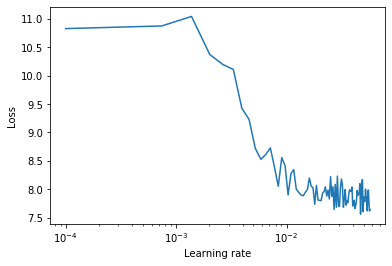

In [0]:
lr_finder.plot_loss()

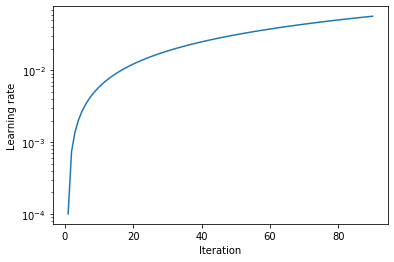

In [0]:
lr_finder.plot_lr()

In [0]:
losses = {
	"gender_output": "binary_crossentropy",
	"image_quality_output": "categorical_crossentropy",
	"age_output": "categorical_crossentropy",
	"weight_output": "categorical_crossentropy",
  "bag_output": "categorical_crossentropy",
  "footwear_output": "categorical_crossentropy",
  "pose_output": "categorical_crossentropy",
  "emotion_output": "categorical_crossentropy",

}
loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
opt = SGD(lr=0.0001, momentum=0.9)
model.compile(
    optimizer=opt,
    # optimizer = 'adam',
    loss=losses,
    # loss="categorical_crossentropy", 
    # loss_weights=loss_weights,
    metrics=["accuracy"]
)

In [0]:
lr_rates = np.geomspace(1e-5,1e-2,10)
def lr_schedule(epoch):
    return lr_rates[(epoch)%10]

In [0]:
save_dir = 'saved_models'
model_name = 'Assignment5_.{epoch:02d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             mode='min',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule,verbose=1)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint,lr_reducer, lr_scheduler]

In [0]:
model_history = model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6,
    epochs=10,
    verbose=1,
    callbacks=callbacks,
)

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
90/90 [==============================] - 97s 1s/step - loss: 7.7734 - gender_output_loss: 0.6330 - image_quality_output_loss: 0.9921 - age_output_loss: 1.4109 - weight_output_loss: 0.9807 - bag_output_loss: 0.9084 - footwear_output_loss: 0.9373 - pose_output_loss: 0.9133 - emotion_output_loss: 0.9092 - gender_output_acc: 0.6192 - image_quality_output_acc: 0.5470 - age_output_acc: 0.4037 - weight_output_acc: 0.6348 - bag_output_acc: 0.5674 - footwear_output_acc: 0.5599 - pose_output_acc: 0.6181 - emotion_output_acc: 0.7161 - val_loss: 7.9537 - val_gender_output_loss: 0.6507 - val_image_quality_output_loss: 1.0120 - val_age_output_loss: 1.4426 - val_weight_output_loss: 0.9741 - val_bag_output_loss: 0.9342 - val_footwear_output_loss: 0.9556 - val_pose_output_loss: 0.9291 - val_emotion_output_loss: 0.9669 - val_gender_output_acc: 0.5978 - val_image_quality_output_acc: 0.5131 - val_age_output_acc: 0.3664 - val_we

In [0]:
model.evaluate_generator(valid_gen,verbose=1)

In [0]:
def evaluate_model(model):
    results = model.evaluate_generator(valid_gen, verbose=1)
    acc = {}
    losses = {}
    for k, v in zip(model.metrics_names, results):
        if k.endswith('acc'):
            acc[k] = v 
        else:
            losses[k] = v
    return acc, losses

In [0]:
evaluate_model(model)

31/31 [==============================] - 11s 343ms/step


({'age_output_acc': 0.3704637096774194,
  'bag_output_acc': 0.5806451612903226,
  'emotion_output_acc': 0.6900201612903226,
  'footwear_output_acc': 0.6058467741935484,
  'gender_output_acc': 0.6844758064516129,
  'image_quality_output_acc': 0.5524193548387096,
  'pose_output_acc': 0.6602822580645161,
  'weight_output_acc': 0.640625},
 {'age_output_loss': 1.4119873277602657,
  'bag_output_loss': 0.8768478151290647,
  'emotion_output_loss': 0.9428292359075239,
  'footwear_output_loss': 0.8661214555463483,
  'gender_output_loss': 0.5754783653443859,
  'image_quality_output_loss': 0.9486578933654293,
  'loss': 7.463599635708716,
  'pose_output_loss': 0.7905774424152989,
  'weight_output_loss': 0.9627684047145229})